# Plotting

In [1]:
import iris
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cmocean
import os
import sys
sys.path.append(os.path.abspath("../lib"))

from cubeprep import CubeListExtract as CLE

def log_norm(M, norders=3):
    vmax = np.max(np.abs(M))
    log_vmax = np.log10(vmax)
    log_norm = matplotlib.colors.LogNorm(vmax = vmax, vmin=10**(log_vmax - norders))
    
    return log_norm

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

fig_format='png'


In [2]:
data_dir = os.path.abspath("/gws/nopw/j04/aopp/astyles/CANAL_DATA/experiments/OpSmplxNoise/CANAL_TESTING_R4_R4_CTL/EXP/")
out_dir = os.path.abspath(data_dir + '/OUTPUT.test/')

print(out_dir)

/gws/nopw/j04/aopp/astyles/CANAL_DATA/experiments/OpSmplxNoise/CANAL_TESTING_R4_R4_CTL/EXP/OUTPUT.test


In [3]:
cube_list = iris.load(out_dir + '/*.nc')
data_list = iris.load(data_dir + '/*grid*.nc')
mask_list = iris.load(data_dir + '/mesh_mask.nc')

/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2206: UserWarning: Ignoring netCDF variable 'salgrad' invalid units 'psu/m'
  warnings.warn(msg)


In [4]:
print(cube_list[14].var_name)

temp_xint_fullwidth


In [5]:
v_cube = CLE(data_list, 'voce')
w_cube = CLE(data_list, 'woce')
rhop_cube = CLE(data_list, 'swsigthet')
ssh_cube = CLE(data_list, 'ssh')
vmask = iris.util.squeeze(CLE(mask_list, 'vmask')).data
tmask = iris.util.squeeze(CLE(mask_list, 'tmask')).data
tmaskutil = iris.util.squeeze(CLE(mask_list, 'tmaskutil')).data
e3t = iris.util.squeeze(CLE(mask_list, 'e3t_0')).data
depth_1d = iris.util.squeeze(CLE(mask_list,'gdept_1d')).data
lat = iris.util.squeeze(CLE(mask_list,'nav_lat')).data
lat_1d = np.mean(lat, axis=-1)

In [6]:
eke_cube = CLE(cube_list, 'eke_year')
eke_zint_cube = CLE(cube_list, 'eke_zint_year')
sf_zint_cube = CLE(cube_list, 'sf_zint')
ACC_cube = CLE(cube_list, 'ACC_transport')
WG_cube = CLE(cube_list, 'WG_transport')
res_ov_cube = CLE(cube_list, 'res_ov')
res_ov_depth_cube = CLE(cube_list, 'res_ov_depth')

temp_range1_cube = CLE(cube_list, 'temp_xint_range1')
temp_range2_cube = CLE(cube_list, 'temp_xint_range2')
temp_fullwidth_cube = CLE(cube_list, 'temp_xint_fullwidth')
sal_range1_cube = CLE(cube_list, 'sal_xint_range1')
sal_range2_cube = CLE(cube_list, 'sal_xint_range2')
sal_fullwidth_cube = CLE(cube_list, 'sal_xint_fullwidth')
rhop_range1_cube = CLE(cube_list, 'rhop_xint_range1')
rhop_range2_cube = CLE(cube_list, 'rhop_xint_range2')
rhop_fullwidth_cube = CLE(cube_list, 'rhop_xint_fullwidth')

WG_transport = np.mean(WG_cube.data)
ACC_transport = np.mean(ACC_cube.data)
depth_array = np.sum(e3t * tmask, axis=-3)
depth_array = np.ma.masked_less_equal(depth_array, 0)

rhop = np.ma.masked_array(rhop_cube.data, mask=np.broadcast_to(~np.ma.make_mask(tmask), rhop_cube.shape))

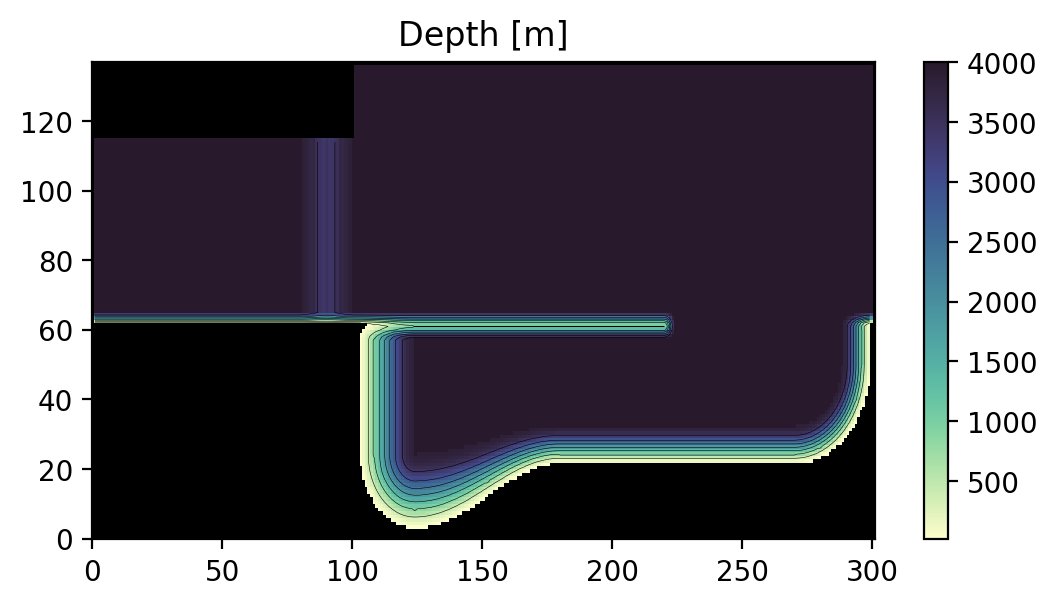

In [8]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Depth [m]")
plt.pcolormesh(depth_array, cmap=cmocean.cm.deep )
plt.colorbar()
CS = plt.contour(depth_array, levels=7, colors='k', linewidths=0.2 )
plt.gca().set_facecolor('k')
plt.savefig(out_dir + '/depth.png', bbox_inches='tight')


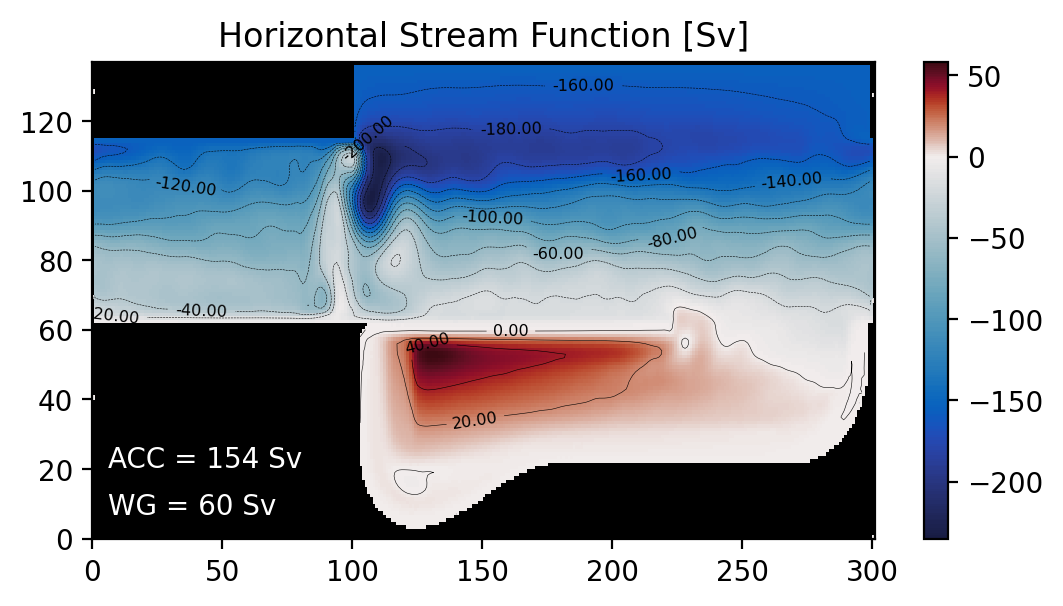

In [9]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Horizontal Stream Function [Sv]")
plt.pcolormesh(np.mean(sf_zint_cube.data[:,:,:],axis=0), cmap=cmocean.cm.balance, norm = matplotlib.colors.TwoSlopeNorm(vcenter=0) )
plt.colorbar()
# plt.gca().set_aspect(1)
CS = plt.contour(np.mean(sf_zint_cube.data[:,:,:],axis=0), norm = matplotlib.colors.TwoSlopeNorm(vcenter=0), levels=15, colors='k', linewidths=0.2 )
plt.gca().set_facecolor('k')
def fmt(x):
        s = f"{x:.2f}"
        if s.endswith("0"):
            s = f"{x:.2f}"
        return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

plt.clabel(CS, CS.levels, inline=True, fontsize='xx-small', fmt=fmt)
plt.text(0.02 ,0.15,fr"ACC = {np.round(ACC_transport):.0f} Sv", transform=plt.gca().transAxes, color='white')
plt.text(0.02 ,0.05,fr"WG = {np.round(WG_transport):.0f} Sv", transform=plt.gca().transAxes, color='white')
plt.savefig(out_dir + f'/sf_zint.{fig_format}', bbox_inches='tight')

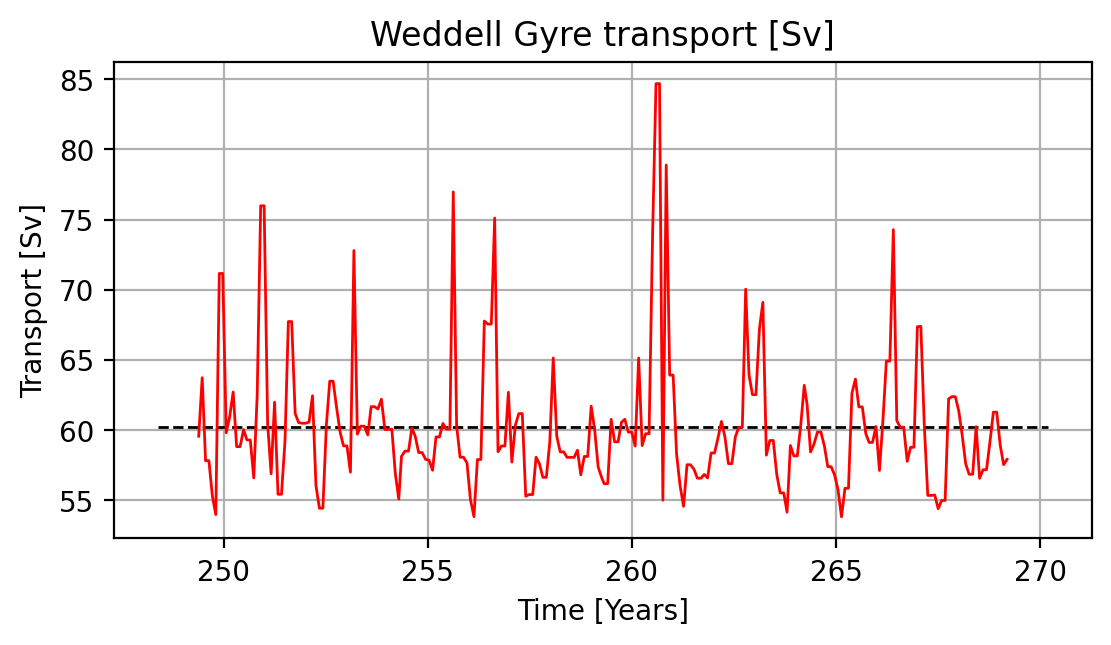

In [10]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Weddell Gyre transport [Sv]")
time_points = (WG_cube.coord("time").points + 1900*365*24*60*60)/(360*24*60*60)
plt.grid(True)
plt.plot(time_points, WG_cube.data, color='red', lw=1)
plt.ylabel(r"Transport [Sv]")
plt.xlabel(r"Time [Years]")
plt.hlines(WG_transport, plt.xlim()[0], plt.xlim()[1], color='black', linestyle='dashed', lw=1)
plt.savefig(out_dir + f'/WG_transport.{fig_format}', bbox_inches='tight')

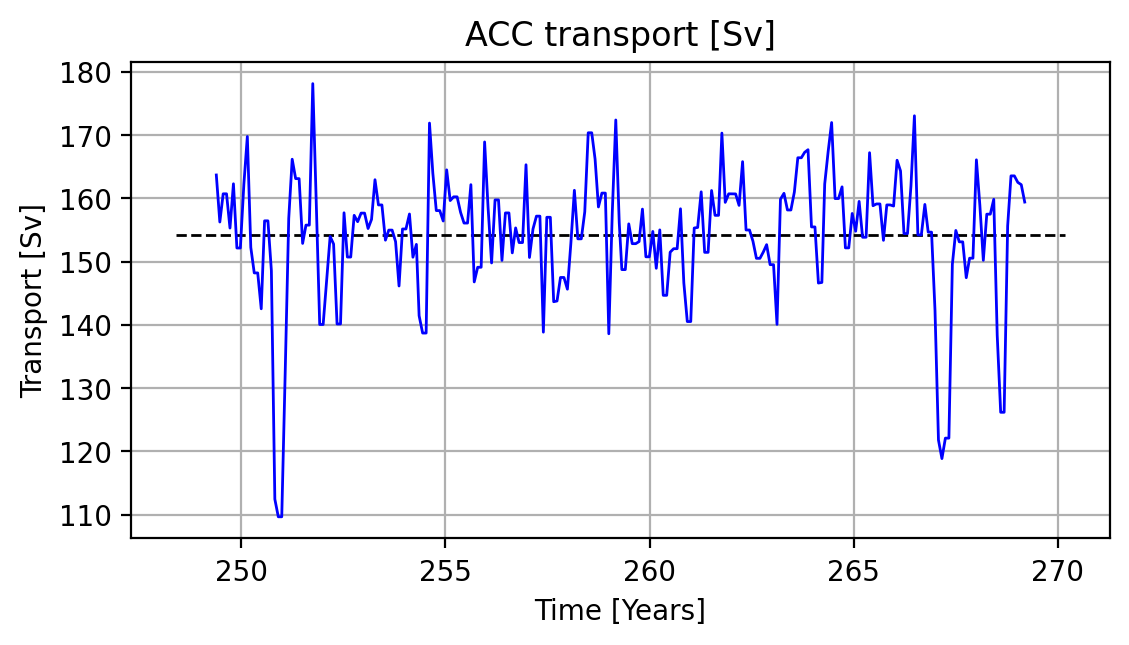

In [11]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"ACC transport [Sv]")
plt.grid(True)
time_points = (ACC_cube.coord("time").points + 1900*365*24*60*60)/(360*24*60*60)
plt.plot(time_points, ACC_cube.data, color='blue', lw=1)
plt.ylabel(r"Transport [Sv]")
plt.xlabel(r"Time [Years]")
plt.hlines(ACC_transport, plt.xlim()[0], plt.xlim()[1], color='black', linestyle='dashed', lw=1)
plt.savefig(out_dir + f'/ACC_transport.{fig_format}', bbox_inches='tight')

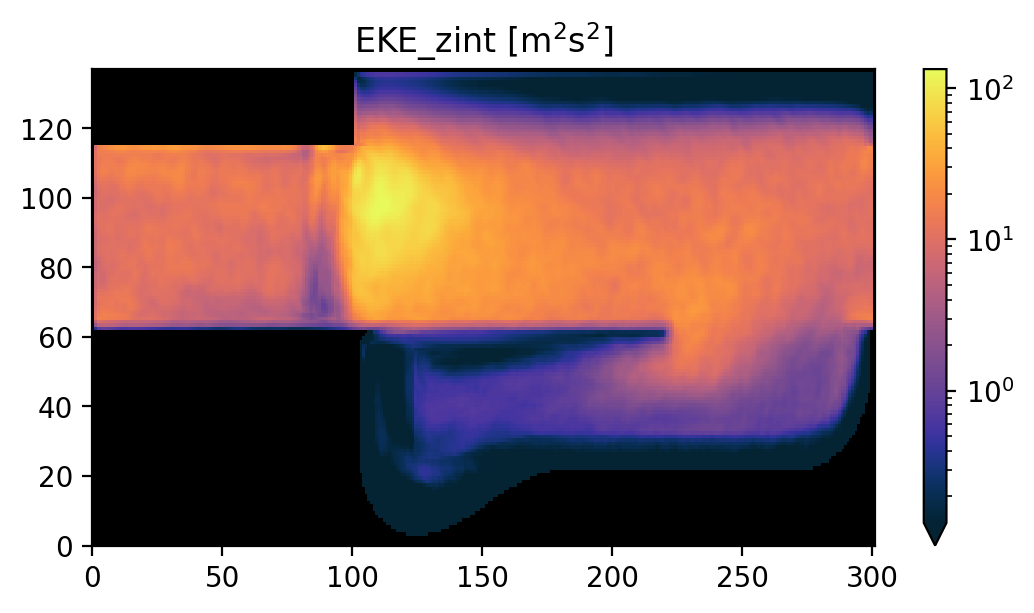

In [30]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"EKE_zint [m$^2$s$^2$]")
plt.pcolormesh(np.mean(eke_zint_cube.data[:,:,:],axis=0), cmap=cmocean.cm.thermal, norm=log_norm(np.mean(eke_zint_cube.data[:,:,:],axis=0)))
plt.colorbar(extend='min')
plt.gca().set_facecolor('k')
plt.savefig(out_dir + f'/EKE.{fig_format}', bbox_inches='tight')

<ipython-input-32-3919dc75030d>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_1d, depth_1d, np.mean(temp_range1_cube.data[:,:,:],axis=0), cmap=cmocean.cm.thermal)


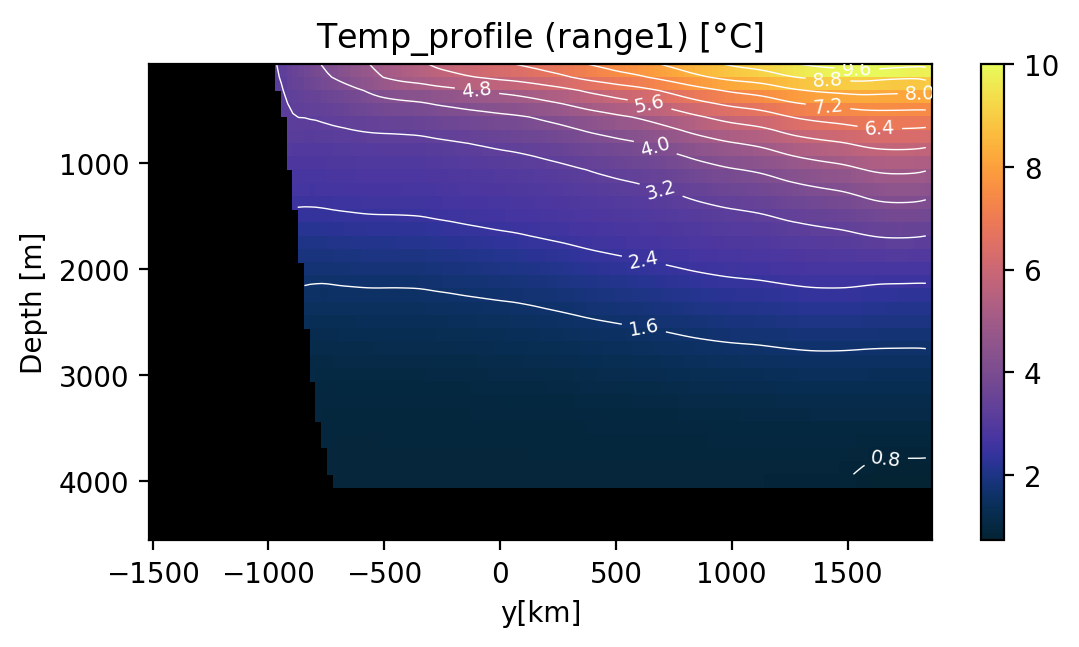

In [32]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Temp_profile (range1) [$\degree$C]")
plt.pcolormesh(lat_1d, depth_1d, np.mean(temp_range1_cube.data[:,:,:],axis=0), cmap=cmocean.cm.thermal)
plt.colorbar()
CS=plt.contour(lat_1d, depth_1d, np.mean(temp_range1_cube.data[:,:,:],axis=0), colors='white', linewidths=0.5, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
plt.gca().set_facecolor('k')
plt.gca().invert_yaxis()
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y[km]")
plt.savefig(out_dir + f'/temp_xint_range1.{fig_format}', bbox_inches='tight')

<ipython-input-33-8466dcafe25c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_1d, depth_1d, np.mean(temp_range2_cube.data[:,:,:],axis=0), cmap=cmocean.cm.thermal)


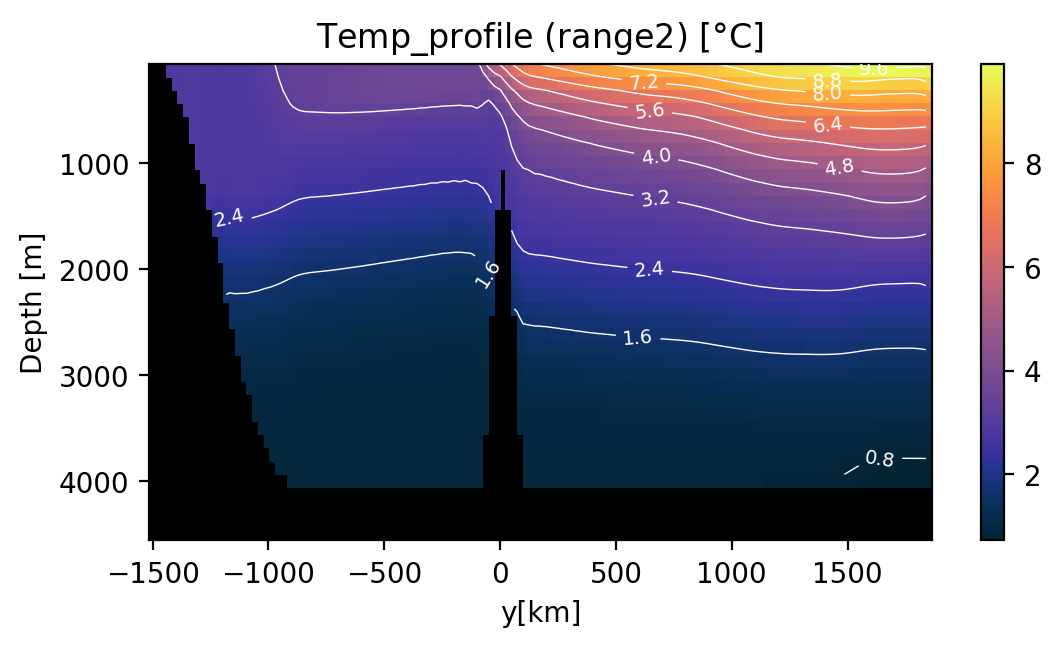

In [33]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Temp_profile (range2) [$\degree$C]")
plt.pcolormesh(lat_1d, depth_1d, np.mean(temp_range2_cube.data[:,:,:],axis=0), cmap=cmocean.cm.thermal)
plt.colorbar()
CS=plt.contour(lat_1d, depth_1d, np.mean(temp_range2_cube.data[:,:,:],axis=0), colors='white', linewidths=0.5, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
plt.gca().set_facecolor('k')
plt.gca().invert_yaxis()
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y[km]")
plt.savefig(out_dir + f'/temp_xint_range2.{fig_format}', bbox_inches='tight')

<ipython-input-34-cd37916eee71>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_1d, depth_1d, np.mean(temp_fullwidth_cube.data[:,:,:],axis=0), cmap=cmocean.cm.thermal)


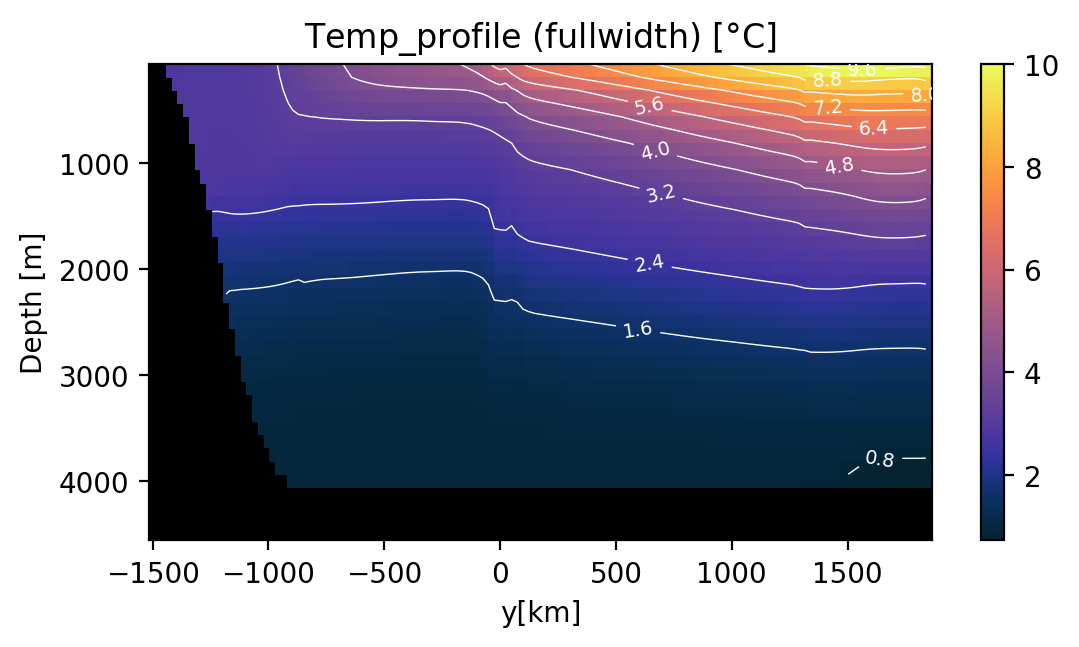

In [34]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Temp_profile (fullwidth) [$\degree$C]")
plt.pcolormesh(lat_1d, depth_1d, np.mean(temp_fullwidth_cube.data[:,:,:],axis=0), cmap=cmocean.cm.thermal)
plt.colorbar()
CS=plt.contour(lat_1d, depth_1d, np.mean(temp_fullwidth_cube.data[:,:,:],axis=0), colors='white', linewidths=0.5, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
plt.gca().set_facecolor('k')
plt.gca().invert_yaxis()
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y[km]")
plt.savefig(out_dir + f'/temp_xint_fullwidth.{fig_format}', bbox_inches='tight')

<ipython-input-35-815b3713e5eb>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_1d, depth_1d, np.mean(sal_range1_cube.data[:,:,:],axis=0), cmap=cmocean.cm.balance, norm=norm)
<ipython-input-35-815b3713e5eb>:10: UserWarning: No contour levels were found within the data range.
  CS=plt.contour(lat_1d, depth_1d, np.mean(sal_range1_cube.data[:,:,:],axis=0), colors='black', linewidths=0.5, levels=11)


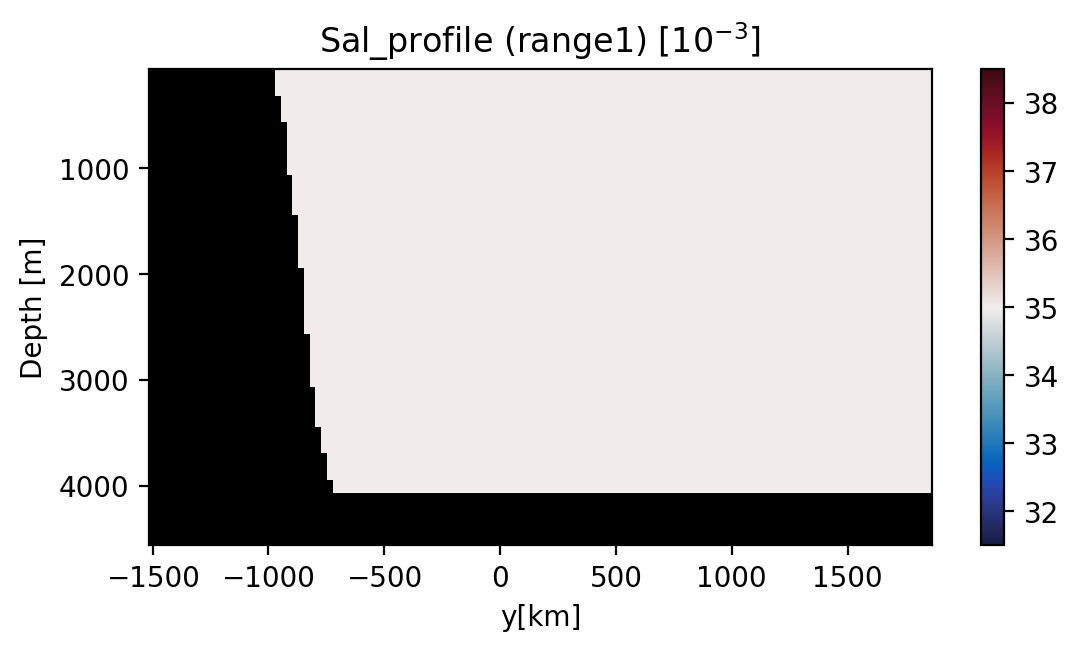

In [35]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Sal_profile (range1) [$10^{-3}$]")
cbarlim = np.max(np.abs(np.mean(sal_range1_cube.data[:,:,:],axis=0)-35))
if (-cbarlim < cbarlim):
    norm=matplotlib.colors.TwoSlopeNorm(vmin = 35-cbarlim, vcenter=35, vmax=35+cbarlim)
else:
    norm=matplotlib.colors.TwoSlopeNorm(vcenter=35)
plt.pcolormesh(lat_1d, depth_1d, np.mean(sal_range1_cube.data[:,:,:],axis=0), cmap=cmocean.cm.balance, norm=norm)
plt.colorbar()
CS=plt.contour(lat_1d, depth_1d, np.mean(sal_range1_cube.data[:,:,:],axis=0), colors='black', linewidths=0.5, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
plt.gca().set_facecolor('k')
plt.gca().invert_yaxis()
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y[km]")
plt.savefig(out_dir + f'/sal_xint_range1.{fig_format}', bbox_inches='tight')

<ipython-input-36-94ade624dc57>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_1d, depth_1d, np.mean(sal_range2_cube.data[:,:,:],axis=0), cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vmin = 35-cbarlim, vcenter=35, vmax=35+cbarlim))
<ipython-input-36-94ade624dc57>:10: UserWarning: No contour levels were found within the data range.
  CS=plt.contour(lat_1d, depth_1d, np.mean(sal_range2_cube.data[:,:,:],axis=0), colors='black', linewidths=0.5, levels=11)


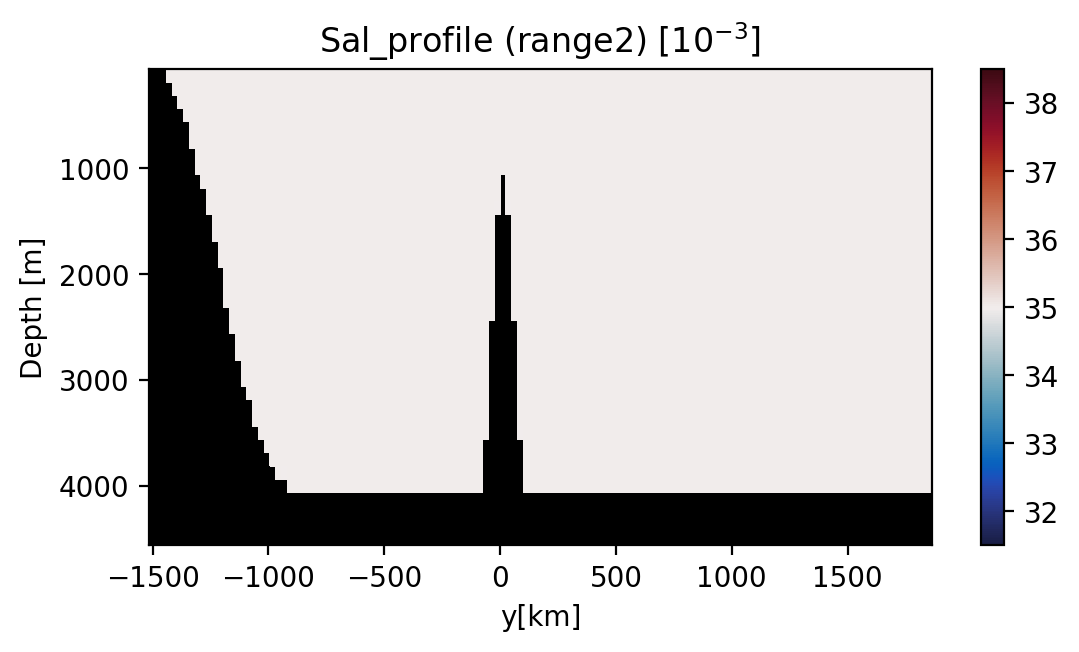

In [36]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Sal_profile (range2) [$10^{-3}$]")
cbarlim = np.max(np.abs(np.mean(sal_range2_cube.data[:,:,:],axis=0)-35))
if (-cbarlim < cbarlim):
    norm=matplotlib.colors.TwoSlopeNorm(vmin = 35-cbarlim, vcenter=35, vmax=35+cbarlim)
else:
    norm=matplotlib.colors.TwoSlopeNorm(vcenter=35)
plt.pcolormesh(lat_1d, depth_1d, np.mean(sal_range2_cube.data[:,:,:],axis=0), cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vmin = 35-cbarlim, vcenter=35, vmax=35+cbarlim))
plt.colorbar()
CS=plt.contour(lat_1d, depth_1d, np.mean(sal_range2_cube.data[:,:,:],axis=0), colors='black', linewidths=0.5, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
plt.gca().set_facecolor('k')
plt.gca().invert_yaxis()
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y[km]")
plt.savefig(out_dir + f'/sal_xint_range2.{fig_format}', bbox_inches='tight')

<ipython-input-37-b9550bb7e223>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_1d, depth_1d, np.mean(sal_fullwidth_cube.data[:,:,:],axis=0), cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vmin = 35-cbarlim, vcenter=35, vmax=35+cbarlim))
<ipython-input-37-b9550bb7e223>:10: UserWarning: No contour levels were found within the data range.
  CS=plt.contour(lat_1d, depth_1d, np.mean(sal_fullwidth_cube.data[:,:,:],axis=0), colors='black', linewidths=0.5, levels=11)


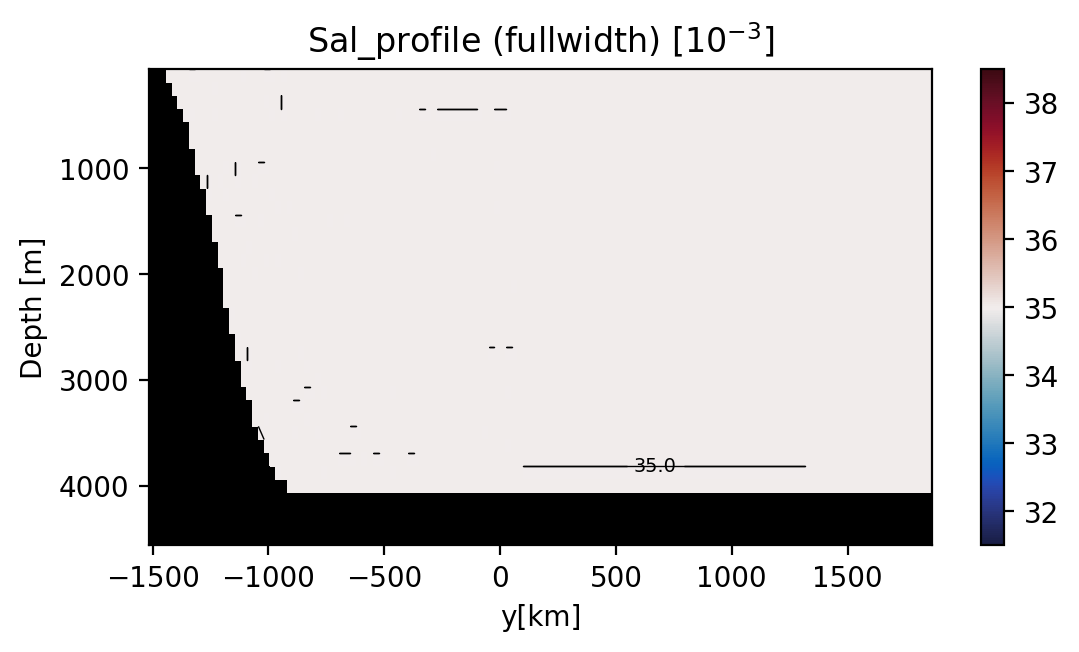

In [37]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Sal_profile (fullwidth) [$10^{-3}$]")
cbarlim = np.max(np.abs(np.mean(sal_fullwidth_cube.data[:,:,:],axis=0)-35))
if (-cbarlim < cbarlim):
    norm=matplotlib.colors.TwoSlopeNorm(vmin = 35-cbarlim, vcenter=35, vmax=35+cbarlim)
else:
    norm=matplotlib.colors.TwoSlopeNorm(vcenter=35)
plt.pcolormesh(lat_1d, depth_1d, np.mean(sal_fullwidth_cube.data[:,:,:],axis=0), cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vmin = 35-cbarlim, vcenter=35, vmax=35+cbarlim))
plt.colorbar()
CS=plt.contour(lat_1d, depth_1d, np.mean(sal_fullwidth_cube.data[:,:,:],axis=0), colors='black', linewidths=0.5, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
plt.gca().set_facecolor('k')
plt.gca().invert_yaxis()
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y[km]")
plt.savefig(out_dir + f'/sal_xint_fullwidth.{fig_format}', bbox_inches='tight')

<ipython-input-39-f4673a904b59>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_1d, depth_1d, np.mean(rhop_range1_cube.data[:,:,:],axis=0)-1000, cmap=cmocean.cm.dense)


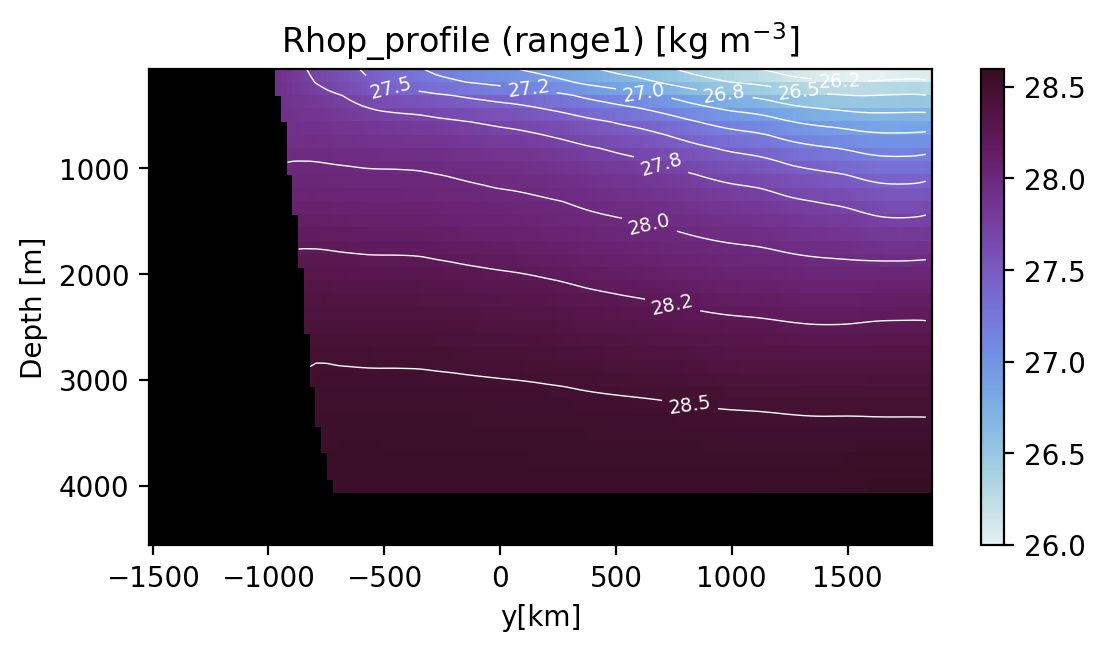

In [39]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Rhop_profile (range1) [kg m$^{-3}$]")
plt.pcolormesh(lat_1d, depth_1d, np.mean(rhop_range1_cube.data[:,:,:],axis=0)-1000, cmap=cmocean.cm.dense)
plt.colorbar()
CS=plt.contour(lat_1d, depth_1d, np.mean(rhop_range1_cube.data[:,:,:],axis=0)-1000, colors='white', linewidths=0.5, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
plt.gca().set_facecolor('k')
plt.gca().invert_yaxis()
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y[km]")
plt.savefig(out_dir + f'/rhop_xint_range1.{fig_format}', bbox_inches='tight')

<ipython-input-40-d752ecf82893>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_1d, depth_1d, np.mean(rhop_range2_cube.data[:,:,:],axis=0)-1000, cmap=cmocean.cm.dense)


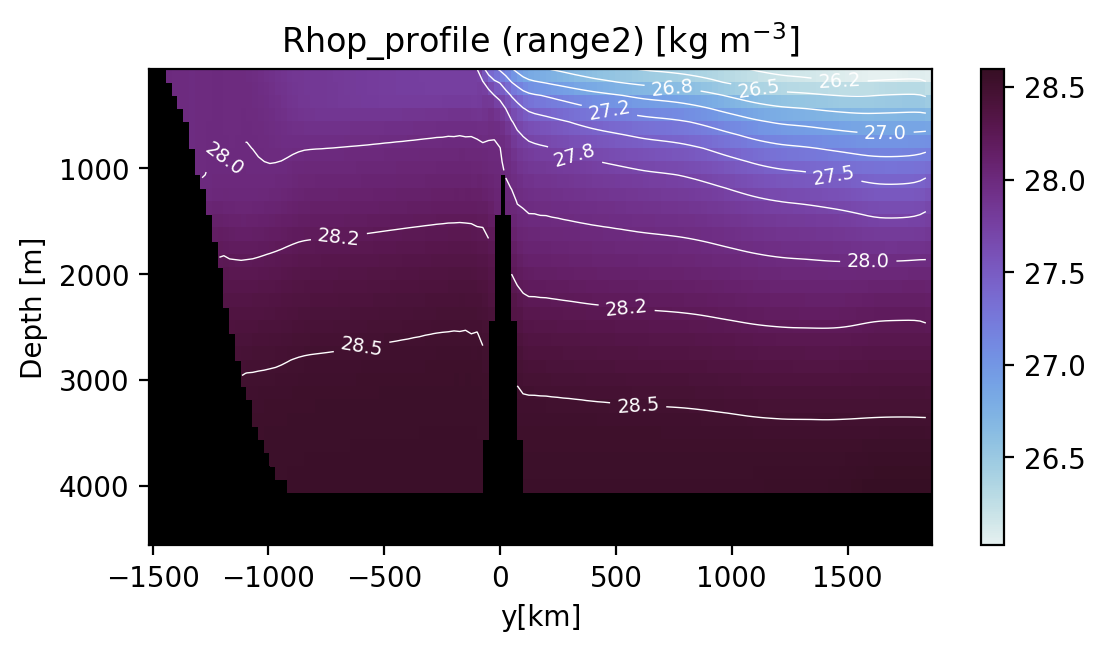

In [40]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Rhop_profile (range2) [kg m$^{-3}$]")
plt.pcolormesh(lat_1d, depth_1d, np.mean(rhop_range2_cube.data[:,:,:],axis=0)-1000, cmap=cmocean.cm.dense)
plt.colorbar()
CS=plt.contour(lat_1d, depth_1d, np.mean(rhop_range2_cube.data[:,:,:],axis=0)-1000, colors='white', linewidths=0.5, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
plt.gca().set_facecolor('k')
plt.gca().invert_yaxis()
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y[km]")
plt.savefig(out_dir + f'/rhop_xint_range2.{fig_format}', bbox_inches='tight')

<ipython-input-41-eb8763fda06d>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat_1d, depth_1d, np.mean(rhop_fullwidth_cube.data[:,:,:],axis=0)-1000, cmap=cmocean.cm.dense)


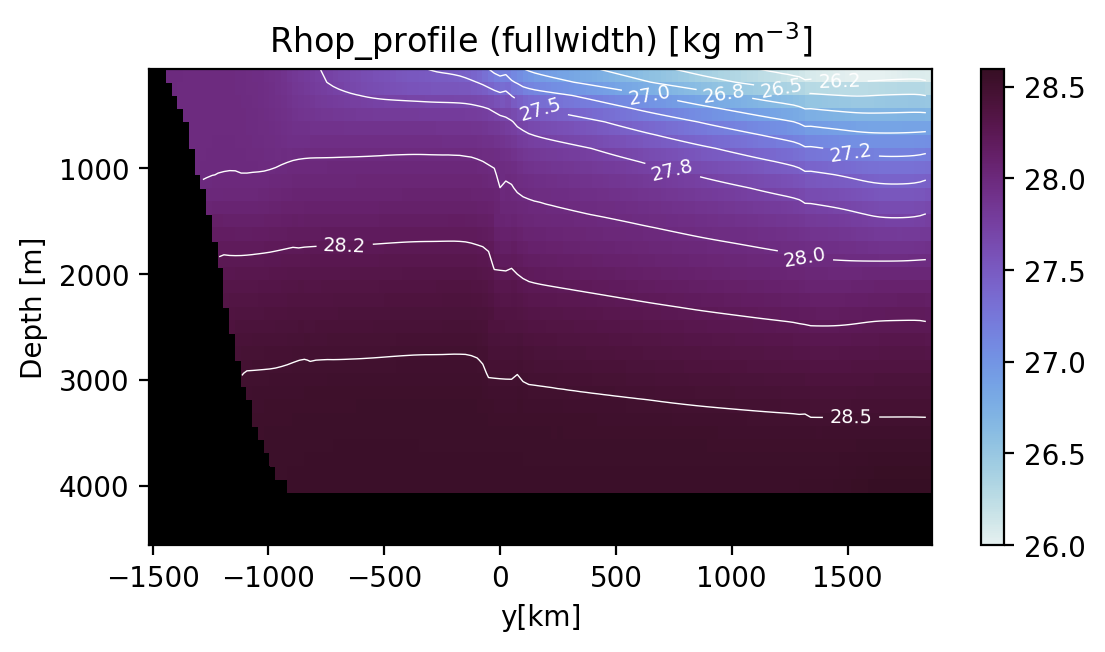

In [41]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Rhop_profile (fullwidth) [kg m$^{-3}$]")
plt.pcolormesh(lat_1d, depth_1d, np.mean(rhop_fullwidth_cube.data[:,:,:],axis=0)-1000, cmap=cmocean.cm.dense)
plt.colorbar()
CS=plt.contour(lat_1d, depth_1d, np.mean(rhop_fullwidth_cube.data[:,:,:],axis=0)-1000, colors='white', linewidths=0.5, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
plt.gca().set_facecolor('k')
plt.gca().invert_yaxis()
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y[km]")
plt.savefig(out_dir + f'/rhop_xint_fullwidth.{fig_format}', bbox_inches='tight')

<ipython-input-22-8b655d80187a>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(res_ov_depth_cube.coord("y_xmean").points, res_ov_depth_cube.coord("InterpDepth").points, res_ov_depth_cube.data, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0), cmap=cmap)


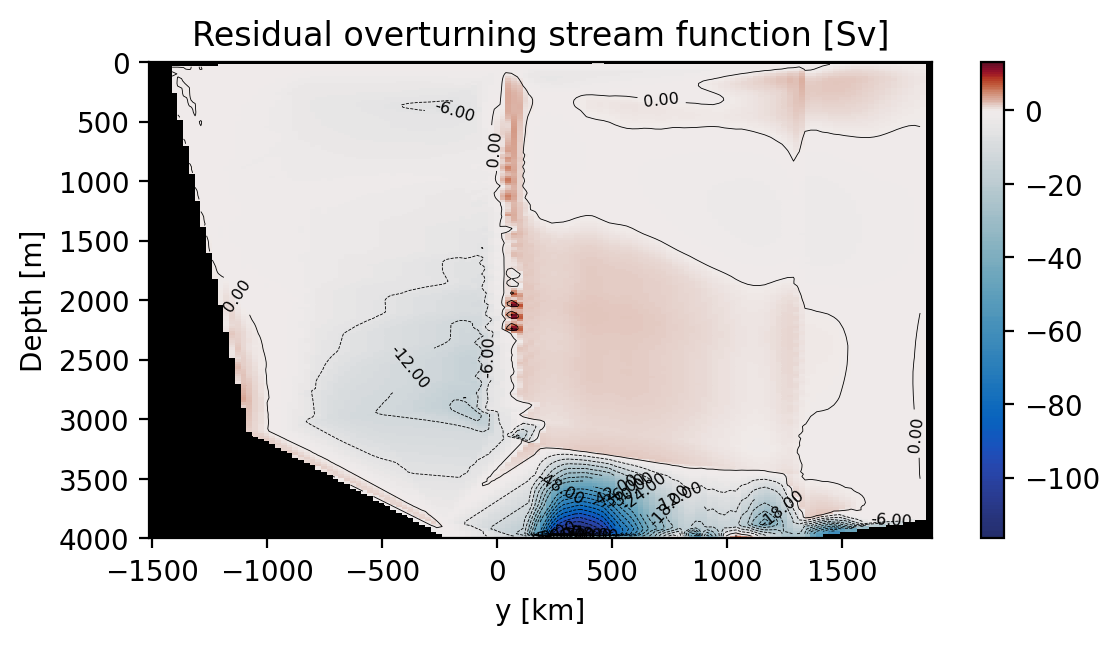

In [22]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Residual overturning stream function [Sv]")
cmap = truncate_colormap(cmocean.cm.balance, 0.05,0.95)
plt.pcolormesh(res_ov_depth_cube.coord("y_xmean").points, res_ov_depth_cube.coord("InterpDepth").points, res_ov_depth_cube.data, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0), cmap=cmap)
plt.colorbar()
CS = plt.contour(res_ov_depth_cube.coord("y_xmean").points, res_ov_depth_cube.coord("InterpDepth").points, res_ov_depth_cube.data, colors='k', linewidths=0.3, levels=21)
plt.clabel(CS, CS.levels, inline=True, fontsize='xx-small', fmt=fmt)
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y [km]")
plt.gca().invert_yaxis()
plt.gca().set_facecolor('k')
plt.savefig(out_dir  + f'/res_ov_depth_xint.{fig_format}', bbox_inches='tight')

In [23]:
# print(res_ov_cube)

Residual overturning function / (Sv) (time: 236; Density_level: 101; -- : 137; -- : 301)
     Dimension coordinates:
          time                            x                   -         -         -
          Density_level                   -                   x         -         -
     Auxiliary coordinates:
          IsopycnalDepth                  x                   x         x         x
          latitude                        -                   -         x         x
          longitude                       -                   -         x         x
     Attributes:
          Conventions: CF-1.5


In [24]:
# IsopDepth = np.ma.masked_array(res_ov_cube.coord("IsopycnalDepth").points[:,:,:,:],mask=res_ov_cube.data.mask)
# IsopDepth = np.ma.masked_greater(IsopDepth, 1e10)
# IsopDepthXmean = np.mean(np.mean(IsopDepth, axis=-1),axis=0)

# tm_res_ov = np.mean( np.sum(res_ov_cube.data[:,...,:], axis=-1), axis=0)
# tm_res_ov = np.ma.masked_greater(tm_res_ov, 1e10)
# tm_res_ov = np.ma.masked_less(tm_res_ov, -1e10)


# lat = v_cube.coord("latitude").points
# lat = np.mean(lat, axis=-1)
# lat = np.broadcast_to(lat, tm_res_ov.shape)

# depth_points = IsopDepthXmean[~tm_res_ov.mask]
# lat_points = lat[~tm_res_ov.mask]
# res_ov_points = tm_res_ov[~tm_res_ov.mask]

In [25]:
# depth_coord = np.linspace(0,4000, num=201)
# lat = v_cube.coord("latitude").points
# lat_coord = np.mean(lat, axis=-1)

# lat_grid, depth_grid = np.meshgrid(lat_coord, depth_coord)

# from scipy.interpolate import griddata

# out_grid = griddata((lat_points, depth_points), res_ov_points, (lat_grid, depth_grid), method='linear')
# out_grid = np.ma.masked_invalid(out_grid)
# bot_ind_depth, bot_ind_y = np.ma.notmasked_edges(out_grid,axis=0)[-1]

# for i in range(len(bot_ind_y)):
#     iy = bot_ind_y[i]
#     idep = bot_ind_depth[i]
# #     print("bot_ind =", idep, "iy = ", iy)
# #     out_grid[:,iy] = out_grid[:,iy] - out_grid[idep,iy]
    

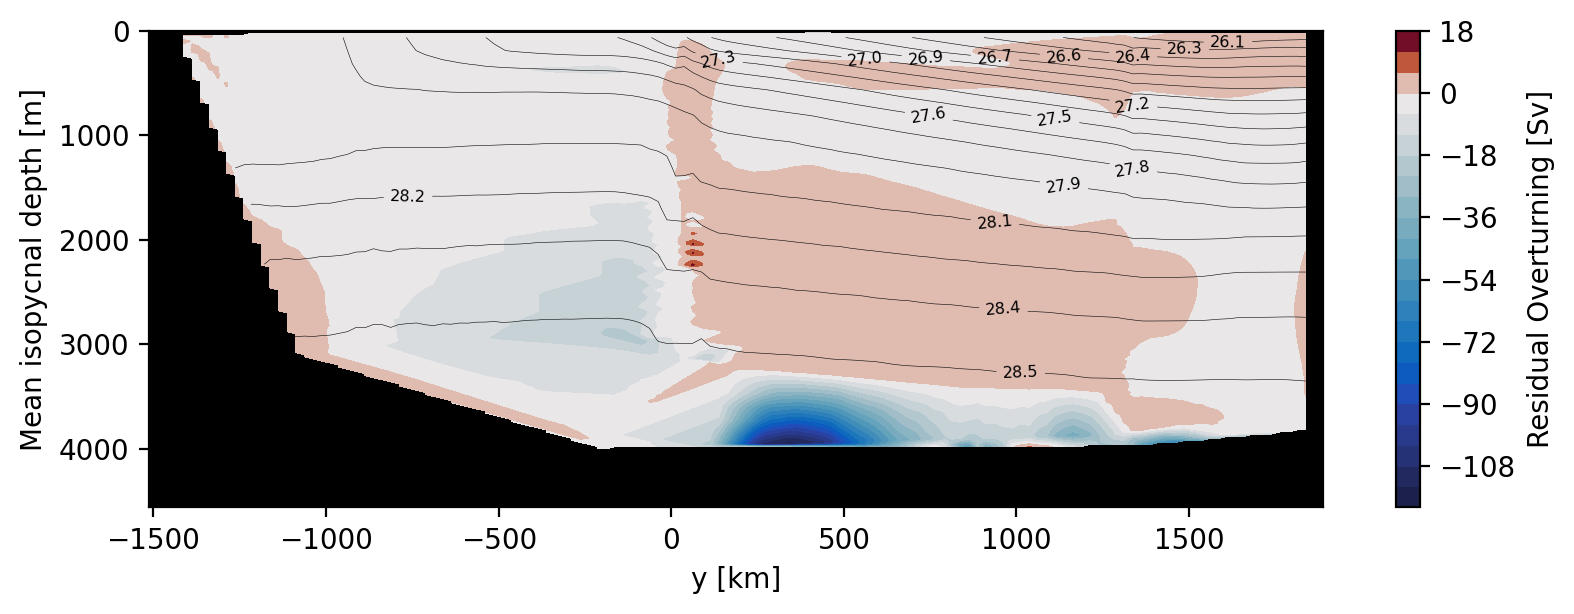

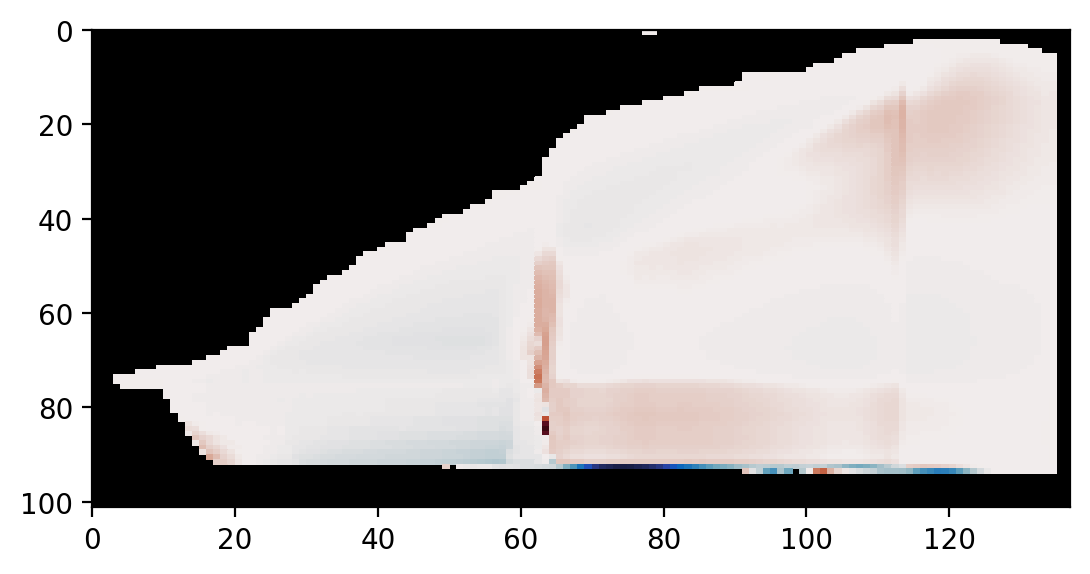

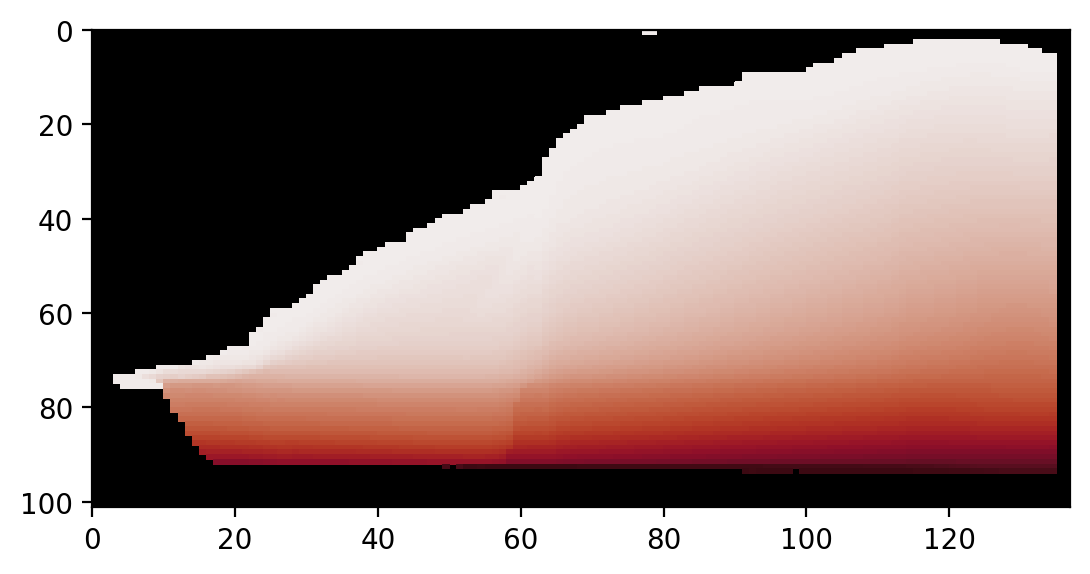

In [26]:
# plt.figure(dpi=200, figsize=(3*3.1554, 3.1554))
# plt.contourf(lat_coord[:], depth_coord[:], out_grid[:,:], cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0), levels=21)
# cbar = plt.colorbar()
# CS = plt.contour(lat_coord[:], rhop_cube.coord("Vertical T levels").points, np.mean(rhop[...,1:-1],axis=(0,-1))[:,:]-1000, colors='k', levels=21, linewidths=0.2)
# def fmt(x):
#         s = f"{x:.1f}"
#         if s.endswith("0"):
#             s = f"{x:.1f}"
#         return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

# plt.clabel(CS, CS.levels, inline=True, fontsize='xx-small', fmt=fmt)

# plt.xlabel(r"y [km]")
# plt.ylabel(r"Mean isopycnal depth [m]")
# cbar.set_label(r"Residual Overturning [Sv]")
# # plt.contour(lat_coord[:60], depth_coord, out_grid[:,:60], norm=matplotlib.colors.TwoSlopeNorm(vcenter=0), levels=31, linewidths=0.1, colors='k')
# plt.gca().invert_yaxis()
# plt.gca().set_facecolor('k')

# plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
# plt.pcolormesh(tm_res_ov, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0))

# def fmt(x):
#         s = f"{x:.1f}"
#         if s.endswith("0"):
#             s = f"{x:.1f}"
#         return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"
# plt.gca().invert_yaxis()
# plt.gca().set_facecolor('k')

# plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
# plt.pcolormesh(IsopDepthXmean, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0))

# def fmt(x):
#         s = f"{x:.1f}"
#         if s.endswith("0"):
#             s = f"{x:.1f}"
#         return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"
# plt.gca().invert_yaxis()
# plt.gca().set_facecolor('k')